In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 36

(112, 35)


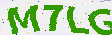

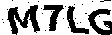

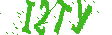

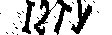

In [40]:
from captchagen import get_captcha_image, generate_captcha, preprocess_image

# 示例使用
image, cookie = get_captcha_image()

# image info
print(image.size)
# show image
from IPython.display import display

display(image)
display(preprocess_image(image))

image, captcha = generate_captcha()
display(image)
display(preprocess_image(image))

In [6]:
import torch
from models.cnn import CaptchaOCR

model = CaptchaOCR().to(device)
import os

if os.path.exists("captcha_ocr.pth"):
    model.load_state_dict(torch.load("captcha_ocr.pth", map_location=device))

/tmp/ipykernel_1056577/1488443610.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("captcha_ocr.pth"))


In [3]:
from models.transformer import CaptchaSolverWithTransformer

model = CaptchaSolverWithTransformer().to(device)
import os

if os.path.exists("captcha_transformer.pth"):
    model.load_state_dict(torch.load("captcha_transformer.pth", map_location=device))

/home/caoziguang/miniconda3/envs/captcha/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_1203494/4085151542.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed t

In [13]:
from models.cnn_transformer import CaptchaSolverWithCNNTransformer

model = CaptchaSolverWithCNNTransformer().to(device)
import os

if os.path.exists("captcha_cnn_transformer.pth"):
    model.load_state_dict(torch.load("captcha_cnn_transformer.pth", map_location=device))

/home/cao/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
from models.resnet import ResNetCaptchaOCR

model = ResNetCaptchaOCR(num_classes=num_classes).to(device)
import os

if os.path.exists("captcha_resnet.pth"):
    model.load_state_dict(torch.load(f"captcha_resnet_{num_classes}.pth", map_location=device))

In [11]:
# save model
def save_model(model):
    if model.__class__.__name__ == "CaptchaOCR":
        torch.save(model.state_dict(), "captcha_ocr.pth")
    elif model.__class__.__name__ == "CaptchaSolverWithTransformer":
        torch.save(model.state_dict(), "captcha_transformer.pth")
    elif model.__class__.__name__ == "ResNetCaptchaOCR":
        torch.save(model.state_dict(), f"captcha_resnet_{model.num_classes}.pth")

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f"runs/{model.__class__.__name__}_{num_classes}")
last_epoch = 0

In [43]:
from torch.utils.data import DataLoader
from dataset import CaptchaDataset

def update_dataset():
    dataset = CaptchaDataset("train", 100000, repeat=8,force=True)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

    test_dataset = CaptchaDataset("test", 256,force=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)
    return dataloader, test_dataloader

In [44]:
dataloader, test_dataloader = update_dataset()

100%|██████████| 100000/100000 [00:37<00:00, 2633.22it/s]


In [47]:
# train model
import torch
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

for epoch in range(last_epoch, 100 + last_epoch):
    # dataloader, test_dataloader = update_dataset() # update dataset every epoch
    last_epoch = epoch
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.view(-1, num_classes), y.argmax(dim=-1).view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean()
    tqdm.write(f"epoch: {epoch}, loss: {loss.item()}, accuracy: {accuracy.item()}")

    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            total_loss += criterion(
                y_pred.view(-1, num_classes), y.argmax(dim=-1).view(-1)
            ).item()
            total_accuracy += (
                (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
            )
        total_loss /= len(test_dataloader)
        tqdm.write(
            f"test loss: {total_loss}, test accuracy: {total_accuracy / len(test_dataloader)}"
        )
    writer.add_scalars("loss", {"train": loss.item(), "test": total_loss}, epoch)
    writer.add_scalars(
        "accuracy",
        {"train": accuracy.item(), "test": total_accuracy / len(test_dataloader)},
        epoch,
    )
    save_model(model)

  0%|          | 0/3125 [00:00<?, ?it/s]

100%|██████████| 3125/3125 [00:56<00:00, 55.39it/s]


epoch: 15, loss: 1.1759858131408691, accuracy: 0.90625
test loss: 1.3274467289447784, test accuracy: 0.865234375


100%|██████████| 3125/3125 [00:56<00:00, 55.19it/s]


epoch: 16, loss: 1.2497868537902832, accuracy: 0.9140625
test loss: 1.3404369503259659, test accuracy: 0.8525390625


100%|██████████| 3125/3125 [00:56<00:00, 55.03it/s]


epoch: 17, loss: 1.1465067863464355, accuracy: 0.9296875
test loss: 1.3203508406877518, test accuracy: 0.8740234375


100%|██████████| 3125/3125 [00:56<00:00, 55.55it/s]


epoch: 18, loss: 1.127511978149414, accuracy: 0.9140625
test loss: 1.3382325619459152, test accuracy: 0.8642578125


100%|██████████| 3125/3125 [00:56<00:00, 55.54it/s]


epoch: 19, loss: 1.2398203611373901, accuracy: 0.890625
test loss: 1.3088880777359009, test accuracy: 0.876953125


100%|██████████| 3125/3125 [00:56<00:00, 55.54it/s]


epoch: 20, loss: 1.2321832180023193, accuracy: 0.90625
test loss: 1.3243741393089294, test accuracy: 0.880859375


100%|██████████| 3125/3125 [00:52<00:00, 59.36it/s]


epoch: 21, loss: 1.2006723880767822, accuracy: 0.8984375
test loss: 1.326237976551056, test accuracy: 0.8623046875


100%|██████████| 3125/3125 [00:53<00:00, 58.56it/s]


epoch: 22, loss: 1.1770161390304565, accuracy: 0.9375
test loss: 1.3320184499025345, test accuracy: 0.8740234375


100%|██████████| 3125/3125 [00:53<00:00, 57.95it/s]


epoch: 23, loss: 1.0834530591964722, accuracy: 0.953125
test loss: 1.3097971081733704, test accuracy: 0.880859375


  4%|▍         | 128/3125 [00:02<00:52, 57.58it/s]


KeyboardInterrupt: 

In [46]:
# eval model
from dataset import CaptchaDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

test_dataset = CaptchaDataset("test", 256)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    total_loss = 0
    total_accuracy = 0
    for x, y in tqdm(test_dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        total_loss += criterion(y_pred.view(-1, num_classes), y.argmax(dim=-1).view(-1)).item()
        total_accuracy += (
            (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
        )
    total_loss /= len(test_dataloader)
    print(
        f"Loss: {total_loss/len(test_dataloader)} Accuracy: {total_accuracy/len(test_dataloader)}"
    )

100%|██████████| 8/8 [00:00<00:00, 56.45it/s]

Loss: 0.11930037382990122 Accuracy: 0.830078125


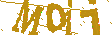

Moii


[('boil', 0.003295802976936102),
 ('boif', 0.0031078422907739878),
 ('boin', 0.003103015711531043),
 ('boim', 0.003028302453458309),
 ('loil', 0.0025652919430285692),
 ('boii', 0.0024346294812858105),
 ('loif', 0.0024189925752580166),
 ('loin', 0.0024152358528226614),
 ('boi8', 0.0023975500371307135),
 ('loim', 0.002357082674279809)]

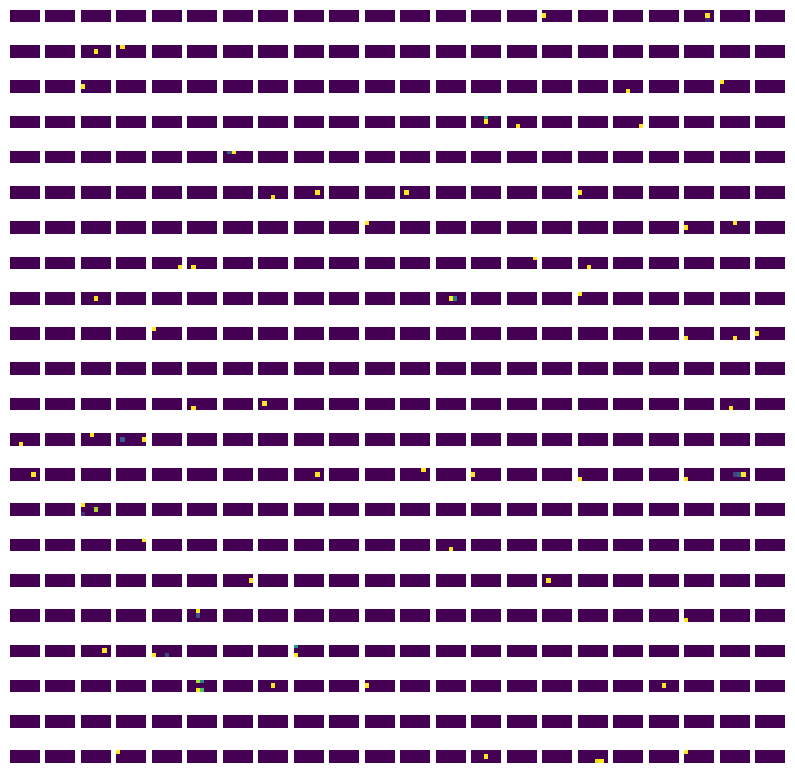

In [48]:
from captchagen import generate_captcha, preprocess_image
from torchvision import transforms


# show middle output of model
def hook_fn(m, i, o):
    global output
    output = o


hook = model.res_layers.register_forward_hook(hook_fn)

# test model
image, captcha = generate_captcha()
display(image)
print(captcha)
image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
display(y_pred)

# get res_layers output
hook.remove()
output = output.squeeze(0)

import matplotlib.pyplot as plt


def plot_res_layers_output(output):
    num_channels = output.size(0)
    grid_size = int(num_channels**0.5)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_channels:
            ax.imshow(output[i].detach().cpu().numpy(), cmap="viridis")
        ax.axis("off")
    plt.show()


plot_res_layers_output(output)

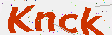

[('khpu', 0.0018755376804620028),
 ('thpu', 0.0018088986398652196),
 ('kapu', 0.0013139134971424937),
 ('tapu', 0.0012672294396907091),
 ('kh3u', 0.0012222654186189175),
 ('th3u', 0.001178837614133954),
 ('khpk', 0.0011593197705224156),
 ('6hpu', 0.0011415547924116254),
 ('thpk', 0.0011181284207850695),
 ('khdu', 0.001016395865008235)]

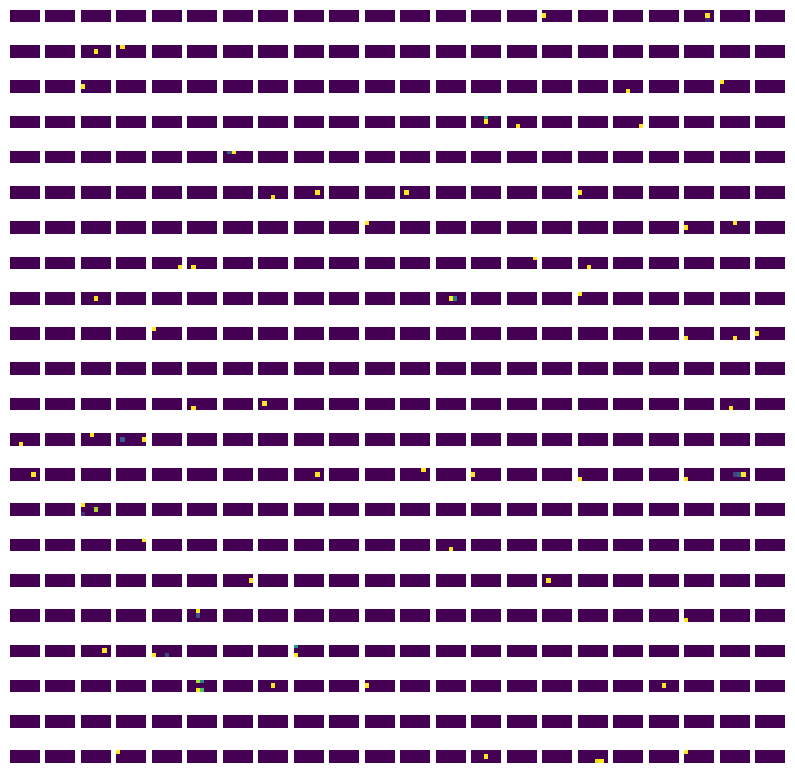

In [65]:
from captchagen import get_captcha_image

# test model on real captcha
image, cookie = get_captcha_image()
display(image)

image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
display(y_pred)

# get res_layers output
hook.remove()
output = output.squeeze(0)

import matplotlib.pyplot as plt


def plot_res_layers_output(output):
    num_channels = output.size(0)
    grid_size = int(num_channels**0.5)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_channels:
            ax.imshow(output[i].detach().cpu().numpy(), cmap="viridis")
        ax.axis("off")
    plt.show()


plot_res_layers_output(output)

In [12]:
save_model(model)